In [227]:
#!/usr/bin/env python
import sys,os
#print sys.path
sys.path=["/home/Zhi/QA-sim","/home/Zhi/april/py"]+sys.path
print(sys.path)
from Parameter import Parameter
from BaseLikelihood import BaseLikelihood
import MCMCAnalyzer
import numpy as np
import quasim as qua
import math
import matplotlib.pyplot as plt
import corner
from uncertainties import ufloat
from uncertainties.umath import sqrt

['/home/Zhi/QA-sim', '/home/Zhi/april/py', '/home/Zhi/QA-sim', '/home/Zhi/april/py', '/home/Zhi/QA-sim', '/home/Zhi/april/py', '/home/Zhi/QA-sim/notebook', '/usr/lib64/python39.zip', '/usr/lib64/python3.9', '/usr/lib64/python3.9/lib-dynload', '', '/home/Zhi/.local/lib/python3.9/site-packages', '/usr/lib64/python3.9/site-packages', '/usr/lib/python3.9/site-packages', '/usr/lib/python3.9/site-packages/IPython/extensions', '/home/Zhi/.ipython']


In [177]:
# Create Input data
# Create star pair position placed in the E-W direction. Dec=0
np.set_pre
QT = qua.QuaTel(DL=np.pi)
BSC = qua.BSC_process("/home/Zhi/QA-sim/bsc5.dat")

lam = 1*10**(-6)
#NEW YORK COORD but the overall baseline is E-W, with B ~ 190m for RA2 = -1.30004
# Change to B~400M for RA2= -1.300085
pos_t_NY = [[-1.3,0.71,6.4*10**(6)],[-1.300085,0.71,6.4*10**(6)]]   #Baseline vector in [RA,DEC,RADIUS] -1.30004
# Baseline vector in [B_EW,B_NS,L=latitude]
pos_t = [200,0,]

#pos = np.array([[0,1.2,0.0,450.0],[0,1.202,0.0,90.0]])
pos = BSC.BSC_filter(pos_t_NY,3)
# Use some sample star, here I use sample pos[0] as a sample star
print(pos[0])
T = 5000   

num, t, baseline, theo_phase, d_source = QT.get_num_photon(pos[0],pos_t_NY,lam,T,'pos')
num = num[0] 
theo_phase = theo_phase[0]

#create simulated data based on theoretical rates generated above
task4 = qua.sim_data(num*10,t,theo_phase,'pos')   

print('theo_d',d_source[0,0,:])
BSC = qua.BSC_process("/home/Zhi/QA-sim/bsc5.dat")

[[4.71700000e+03 3.24765777e+00 4.55506694e-01 3.08390779e+01]
 [4.70700000e+03 3.23978924e+00 4.51099738e-01 4.33612091e+01]]
theo_d [ 0.0026411  -0.00684019  0.00396187]


In [252]:
np.set_printoptions(precision=15)
print(d_source[0,0,:])

[ 0.002641097556069 -0.006840186186503  0.003961874392963]


Text(0, 0.5, 'Rates[Hz]')

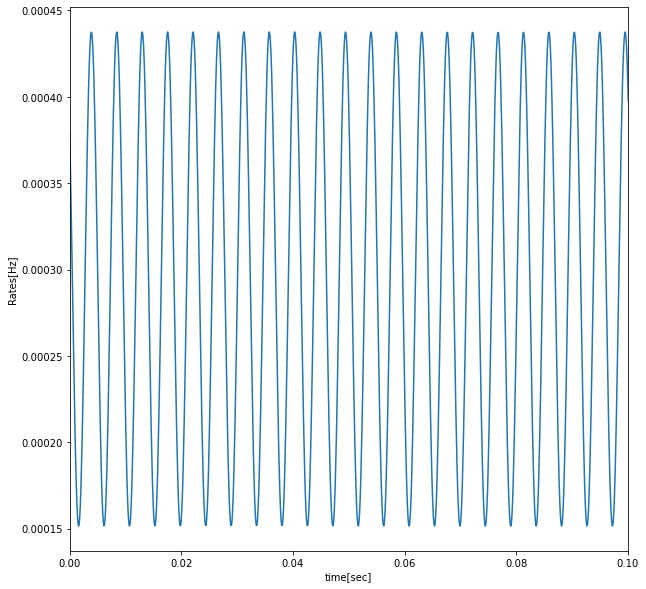

In [25]:
plt.figure(figsize=(10,10))
plt.xlim([0,0.1])
plt.plot(t[0:55000],num[0:55000],label='Theo rate curve')
#plt.scatter(task4.timestamp,task4.sim_num)
plt.xlabel('time[sec]');plt.ylabel('Rates[Hz]')
#plt.legend()

In [253]:
# Find theoretical separation of two sources in d_ew and d_ns of the tangent plane centered at dec_mid and ra_mid
def theo_ds(pos_s,theo):
    pos = np.delete(pos_s,0,axis=1)
    x = np.cos(pos[:,1])*np.cos(pos[:,0])
    y = np.cos(pos[:,1])*np.sin(pos[:,0])
    z = np.sin(pos[:,1])
               
    s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    phi = math.atan2((y[0]+y[1]),(x[0]+x[1]))
     
    # Use theo d_source in cart to convert to d_ns and d_ew
    #d_ns_theo = theo[2]/s     #
    #d_ew_theo = (theo[1]+np.sin(phi)*((z[0]+z[1])/2)*d_ns_theo)/np.cos(phi)
 
    d_ns_theo = pos[0,1]-pos[1,1]
    d_ew_theo = (pos[0,0]-pos[1,0])*s
    
    return d_ew_theo, d_ns_theo

d_ew_theo, d_ns_theo = theo_ds(pos[0],d_source[0,0,:])
theo_par = [task4.V, d_ew_theo, d_ns_theo, QT.ph]
print(theo_par)
#theo_par = [task4.V,0.0070738038903991616, 0.004406959336378575, QT.ph]
theo_par

[0.48575982471026546, 0.007073775543602213, 0.004406956361285741, -2.1765595179585695]


[0.48575982471026546,
 0.007073775543602213,
 0.004406956361285741,
 -2.1765595179585695]

In [243]:
# Find theoretical separation of two sources in d_ew and d_ns of the tangent plane centered at dec_mid and ra_mid
def theo_ds(pos_t,pos_s):
    pos = np.delete(pos_s,0,axis=1)
    pos_t = np.array(pos_t)
    x = np.cos(pos[:,1])*np.cos(pos[:,0])
    y = np.cos(pos[:,1])*np.sin(pos[:,0])
    z = np.sin(pos[:,1])
               
    s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    
    ra_mid = math.atan2((y[0]+y[1]),(x[0]+x[1]))
    dec_mid = np.arcsin((z[0]+z[1])/2)
    
    DN = pos[0,1]-pos[1,1]
    DE = (pos[0,0]-pos[1,0])*np.cos(dec_mid)
    
    BN = pos_t[1,1]-pos_t[0,1]
    BE = pos_t[1,0]-pos_t[0,0] * np.cos((pos_t[1,1]+pos_t[0,1])/2)
    
    return DN, DE, BN, BE

DN,DE,BN,BE =theo_ds(pos_t_NY, pos[0])
print('Theoretical source separation in tangent plane:', DE, 'and', DN)
print('Baseline separation in tangent plane', BN, 'and', BE)

theo_par = [task4.V, DE, DN, QT.ph]
print(theo_par)

Theoretical source separation in tangent plane: 0.007073851537357795 and 0.004406956361285741
Baseline separation in tangent plane 0.0 and -0.31421456121233926
[0.48575982471026546, 0.007073851537357795, 0.004406956361285741, -2.1765595179585695]


In [289]:
# create sim_data class for mcmc

class sim_data(BaseLikelihood):
    
    def __init__(self, seed, pos_t, pos_s, t, lam,theo_d):  # seed = [V_init,d_ra_init, d_dec_init]
        BaseLikelihood.__init__(self,"sim_data")  
        
        # free par
        self.seed = seed
        self.V = seed[0]
        self.d_ew = seed[1]
        self.d_ns = seed[2]
        self.offset = seed[3]
        
        # fixed values
        self.t = t             # timestamp for the sim data
        
        pos_t = np.array(pos_t)
        pos_t[:,1] = np.pi/2 - pos_t[:,1]
        self.pos_t = pos_t     # position of the two telescope in Earth coordinate
        
        pos_s = np.delete(pos_s, 0, axis=1)  # delete star # part.
        self.pos_s = pos_s     # position of sources to determine midpoint
        
        self.lam = lam         # lambda for observation
        self.Omega_E = 7.292e-5
        self.theo_d = theo_d
    def freeParameters(self):
        return [
                Parameter("V", self.seed[0], err=0.05),    #0.05
                Parameter("d_ew",self.seed[1], err=1e-9),   #1e-7
                Parameter("d_ns",self.seed[2], err=1e-9),
                Parameter("offset",self.seed[3], err=np.pi/5)   #pi/10
                ]
    
    def updateParams(self,params):    #params is also a class, updates param value.
        for p in params:
            if p.name=="V":
                self.V=p.value
            if p.name=="d_ew":
                self.d_ew=p.value
            if p.name=="d_ns":
                self.d_ns=p.value
            if p.name=="offset":
                self.offset=p.value
                
    def pos_carte(self, ti):
    
            if (ti == 0.0).all() :   # 
                x = np.cos(self.pos_s[:,1])*np.cos(self.pos_s[:,0])
                y = np.cos(self.pos_s[:,1])*np.sin(self.pos_s[:,0])
                z = np.sin(self.pos_s[:,1])
               
                s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    
                ra_mid = math.atan2(y[0]+y[1],x[0]+x[1])
                dec_mid = np.arcsin((z[0]+z[1])/2)
                
                fin_z = np.cos(dec_mid)*self.d_ns
                fin_x = -np.cos(ra_mid)*np.sin(dec_mid)*self.d_ns - np.sin(ra_mid)*self.d_ew
                fin_y = -np.sin(ra_mid)*np.sin(dec_mid)*self.d_ns + np.cos(ra_mid)*self.d_ew
                
                new_pos = np.array([fin_x,fin_y,fin_z])  

                return new_pos
            else:
                N = ti.size 
                
                new_t = np.tile(ti,(2,1))   # (2,N)
            
                pos_tile = np.tile(np.reshape(self.pos_t,(2,1,3)),(1,N,1))    #pos of telescope, 2,N,3
                
                new_pos = np.zeros((2,N,3))
            
                #change from spherical to cartesian
                new_pos[:,:,0] = pos_tile[:,:,2]*np.sin(pos_tile[:,:,1])*np.cos(pos_tile[:,:,0] + self.Omega_E*new_t)   #[x,y,z](t)
                new_pos[:,:,1] = pos_tile[:,:,2]*np.sin(pos_tile[:,:,1])*np.sin(pos_tile[:,:,0] + self.Omega_E*new_t)
                new_pos[:,:,2] = pos_tile[:,:,2]*np.cos(pos_tile[:,:,1])     

                return new_pos
    
    
    def get_phase(self):       #pos:[[[ra,dec,r],[ra,dec,r]],[[],[]]]
        new_pos_s = self.pos_carte(np.array([0.]))
        #new_pos_s = self.theo_d
        print(new_pos_s)
        
        new_pos_t = self.pos_carte(self.t)           #(2,N,3)
        baseline = new_pos_t[1] - new_pos_t[0]      #(3,N)

        dot = baseline[:,0]*new_pos_s[0]+baseline[:,1]*new_pos_s[1]+baseline[:,2]*new_pos_s[2]
        phase = 2*np.pi/self.lam*dot + self.offset   # Total phase with the offset
        
        return phase
    
    
    def loglike_wprior(self):
        
        phase = self.get_phase()
        loglike = np.log(1+self.V*np.cos(phase))  #get loglike for diff phase in 2d array[[],[],[]...]
        res = np.sum(loglike, axis=None)
        
        return res
    

In [290]:
pos = BSC.BSC_filter(pos_t_NY,3)
print('Theoretical separation =', d_source[0,0,:])
#can also use theoretical par value by changing  par to theo_par
L=sim_data(theo_par,pos_t_NY,pos[0],T,lam,d_source[0,0,:])  
L.loglike_wprior()


Theoretical separation = [ 0.002641097556069 -0.006840186186503  0.003961874392963]
[ 0.002641076700169 -0.006840159828614  0.003961879881367]


-2.1536506113270226

[ 0.002641076700169 -0.006840159828614  0.003961879881367]


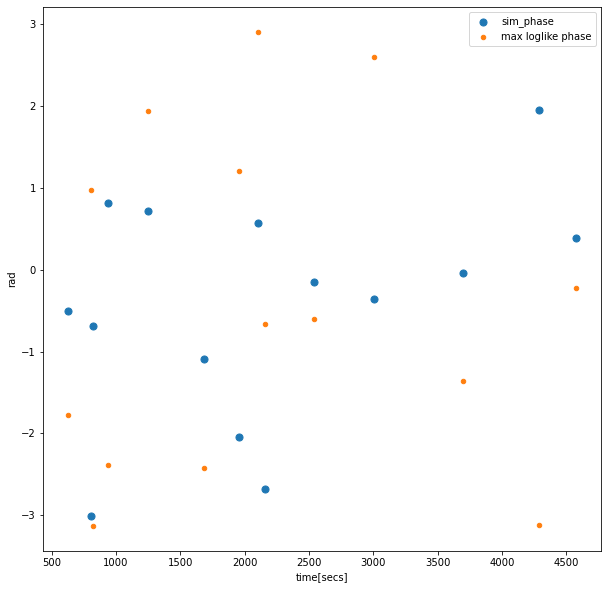

In [291]:
plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)
#plt.plot(t[:200000], np.mod((theo_phase[:200000]+ np.pi),2*np.pi) - np.pi, color = 'g',label='theo phase curve')
plt.scatter(task4.timestamp[:],np.mod((task4.phase[:]+ np.pi),2*np.pi) - np.pi,s=50, label = 'sim_phase')
plt.scatter(task4.timestamp[:], np.mod((L.get_phase()[:]+ np.pi),2*np.pi) - np.pi, s= 20,label = 'max loglike phase')
plt.xlabel('time[secs]');plt.ylabel('rad')
#plt.xlim([19.0,20])
plt.legend()

In [ ]:
MCMCAnalyzer.MCMCAnalyzer(L,"/home/Zhi/QA-sim/MCMC_output/sim_data_400m_10x",temp=2, nsamp=300000)